# Evaluation of RAG Using Ragas

In the following notebook we'll explore how to evaluate RAG pipelines using a powerful open-source tool called "Ragas". This will give us tools to evaluate component-wise metrics, as well as end-to-end metrics about the performance of our RAG pipelines.

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room Part #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating a simple RAG pipeline with [LangChain v0.2.0](https://python.langchain.com/v0.2/docs/versions/v0_2/)
  4. Synthetic Dataset Generation for Evaluation using the [Ragas](https://github.com/explodinggradients/ragas) framework.
  

- 🤝 Breakout Room Part #2:
  1. Evaluating our pipeline with Ragas
  3. Making Adjustments to our RAG Pipeline
  4. Evaluating our Adjusted pipeline against our baseline
  5. Testing OpenAI's Claim

The only way to get started is to get started - so let's grab our dependencies for the day!

> NOTE: Using this notebook as presented will occur a charge of ~$3USD from OpenAI usage. Most of this cost is produced by the Synthetic Data Generation step - if you want to reduce costs, please use the provided commented code to leverage `GPT-3.5-Turbo` as the `critic_llm`!

## Motivation

A claim, made by OpenAI, is that their `text-embedding-3-small` is better (generally) than their `text-embedding-ada-002` model.

Here's some passages from their [blog](https://openai.com/blog/new-embedding-models-and-api-updates) about the `text-embedding-3` release:

> `text-embedding-3-small` is our new highly efficient embedding model and provides a significant upgrade over its predecessor, the `text-embedding-ada-002` model...

> **Stronger performance.** Comparing `text-embedding-ada-002` to `text-embedding-3-small`, the average score on a commonly used benchmark for multi-language retrieval ([MIRACL](https://github.com/project-miracl/miracl)) has increased from 31.4% to 44.0%, while the average score on a commonly used benchmark for English tasks ([MTEB](https://github.com/embeddings-benchmark/mteb)) has increased from 61.0% to 62.3%.

Well, with a library like Ragas - we can put that claim to the test!

If what they claim is true - we should see an increase on related metrics by using the new embedding model!

# 🤝 Breakout Room Part #1

## Task 1: Installing Required Libraries

A reminder that one of the [key features](https://blog.langchain.dev/langchain-v0-1-0/) of LangChain v0.1.0 is the compartmentalization of the various LangChain ecosystem packages!

So let's begin grabbing all of our LangChain related packages!

In [ ]:
!pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 461.3 kB/s eta 0:00:00


We'll also get the "star of the show" today, which is Ragas!

In [ ]:
!pip install -qU ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.

We'll be leveraging [QDrant](https://qdrant.tech/) again as our LangChain `VectorStore`.

We'll also install `pymupdf` and its dependencies which will allow us to load PDFs using the `PyMuPDFLoader` in the `langchain-community` package!

In [ ]:
!pip install -qU qdrant-client pymupdf pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.1/230.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.1 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you hav

## Task 2: Set Environment Variables

Let's set up our OpenAI API key so we can leverage their API later on.

In [ ]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

Please provide your OpenAI Key: ··········


## Task 3: Creating a Simple RAG Pipeline with LangChain v0.1.0

Building on what we learned last week, we'll be leveraging LangChain v0.1.0 and LCEL to build a simple RAG pipeline that we can baseline with Ragas.

## Building our RAG pipeline

Let's review the basic steps of RAG again:

- Create an Index
- Use retrieval to obtain pieces of context from our Index that are similar to our query
- Use a LLM to generate responses based on the retrieved context

Let's get started by creating our index.

> NOTE: We're going to start leaning on the term "index" to refer to our `VectorStore`, `VectorDatabase`, etc. We can think of "index" as the catch-all term, whereas `VectorStore` and the like relate to the specific technologies used to create, store, and interact with the index.

### Creating an Index

You'll notice that the largest changes (outside of some import changes) are that our old favourite chains are back to being bundled in an easily usable abstraction.

We can still create custom chains using LCEL - but we can also be more confident that our pre-packaged chains are creating using LCEL under the hood.

#### Loading Data

Let's start by loading some data!

> NOTE: You'll notice that we're using a document loader from the community package of LangChain. This is part of the v0.2.0 changes that make the base (`langchain-core`) package remain lightweight while still providing access to some of the more powerful community integrations.

In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader(
    "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf",
)

documents = loader.load()

In [ ]:
documents[0].metadata

{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf',
 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf',
 'page': 0,
 'total_pages': 195,
 'format': 'PDF 1.3',
 'title': 'The Pmarca Blog Archives',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': '',
 'producer': 'Mac OS X 10.10 Quartz PDFContext',
 'creationDate': "D:20150110020418Z00'00'",
 'modDate': "D:20150110020418Z00'00'",
 'trapped': ''}

#### Transforming Data

Now that we've got our single document - let's split it into smaller pieces so we can more effectively leverage it with our retrieval chain!

We'll start with the classic: `RecursiveCharacterTextSplitter`.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 50
)

documents = text_splitter.split_documents(documents)

Let's confirm we've split our document.

In [ ]:
len(documents)

1864

#### Loading OpenAI Embeddings Model

We'll need a process by which we can convert our text into vectors that allow us to compare to our query vector.

Let's use OpenAI's `text-embedding-ada-002` for this task!

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

#### Creating a QDrant VectorStore

Now that we have documents - we'll need a place to store them alongside their embeddings.

In [ ]:
from langchain_community.vectorstores import Qdrant

qdrant_vector_store = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="PMarca Blogs",
)

####❓ Question #1:

List out a few of the techniques that Qdrant uses that make it performant.

> Vector Quantization: Reduces the size of vector data, speeding up search queries while maintaining accuracy.
Parallel Processing: Handles multiple search queries simultaneously, improving throughput and reducing latency.
HNSW (Hierarchical Navigable Small World Graphs): Enables efficient nearest neighbor searches, ensuring fast and scalable query processing.

#### Creating a Retriever

To complete our index, all that's left to do is expose our vectorstore as a retriever - which we can do the same way we would in previous version of LangChain!

In [ ]:
retriever = qdrant_vector_store.as_retriever()

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [ ]:
retrieved_documents = retriever.invoke("What is a rule of thumb for selecting an industry to invest in?")

In [ ]:
for doc in retrieved_documents:
  print(doc)

page_content='the existing order — and make sure that those forces of change\nhave a reasonable chance at succeeding.\nSecond rule of thumb:\nOnce you have picked an industry, get right to the center of it' metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 125, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '8cb47697fc4543a8b47722ffa9e1664d', '_collection_name': 'PMarca Blogs'}
page_content='Third rule:\nIn a rapidly changing Held like technology, the best place to\nget experience when you’re starting out is in younger, high-\ngrowth companies.' metadata={'source': 'https://d1lamhf6l6yk6d

### Creating a RAG Chain

Now that we have the "R" in RAG taken care of - let's look at creating the "AG"!

#### Creating a Prompt Template

There are a few different ways we could create our prompt template - we could create a custom template, as seen in the code below, or we could simply pull a prompt from the prompt hub! Let's look at an example of that!

In [ ]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

In [ ]:
print(retrieval_qa_prompt.messages[0].prompt.template)

Answer any use questions based solely on the context below:

<context>
{context}
</context>


As you can see - the prompt template is simple (and has a small error) - so we'll create our own to be a bit more specific!

In [ ]:
from langchain.prompts import ChatPromptTemplate

template = """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(template)

#### Setting Up our Basic QA Chain

Now we can instantiate our basic RAG chain!

We'll use LCEL directly just to see an example of it - but you could just as easily use an abstraction here to achieve the same goal!

We'll also ensure to pass-through our context - which is critical for RAGAS.

In [ ]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}

)

# we merge the question and retriever (context and pass it through to generate response)

####🏗️ Activity #1:

Describe the pipeline shown above in simple terms. You can include a diagram if desired.
In summary, the pipeline takes a user's question, retrieves relevant information to provide context, passes this context along, and then uses both the question and the context to generate a detailed answer.

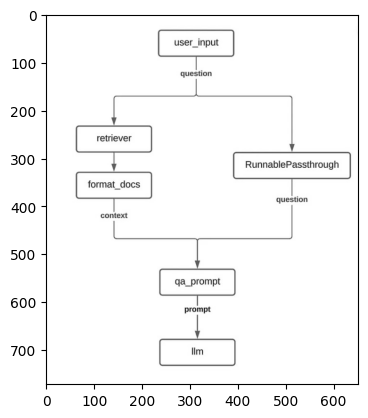

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('screenshot.jpg')
imgplot = plt.imshow(img)
plt.show()

Let's test it out!

In [ ]:
question = "What is a rule of thumb for selecting an industry to invest in?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)

Get right to the center of the industry.


In [ ]:
question = "What did Pink Floyd have to say about how to proceed when investing in a new industry?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)
print(result["context"])

I don't know.
[Document(page_content='ask if you can call them again if things change.\nTrust me — they’d much rather be saying “yes” than “no” —\nthey need all the good investments they can get.\nSecond, consider the environment.', metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 15, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '2d0ee161f6564212adb5f9c9a0461b9f', '_collection_name': 'PMarca Blogs'}), Document(page_content='watching carefully — if everyone agrees right up front that\nwhatever you are doing makes total sense, it probably isn’t a new\nand radical enough idea to justify a

We can already see that there are some improvements we could make here.

For now, let's switch gears to RAGAS to see how we can leverage that tool to provide us insight into how our pipeline is performing!

## Task 4: Synthetic Dataset Generation for Evaluation using Ragas

Ragas is a powerful library that lets us evaluate our RAG pipeline by collecting input/output/context triplets and obtaining metrics relating to a number of different aspects of our RAG pipeline.

We'll be evaluating on every core metric today, but in order to do that - we'll need to create a test set. Luckily for us, Ragas can do that directly!

### Synthetic Test Set Generation

We can leverage Ragas' [`Synthetic Test Data generation`](https://docs.ragas.io/en/stable/concepts/testset_generation.html) functionality to generate our own synthetic QC pairs - as well as a synthetic ground truth - quite easily!

In [ ]:
loader = PyMuPDFLoader(
    "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf",
)

eval_documents = loader.load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

####❓ Question #2:

Why is it important to split our documents using different parameters when creating our synthetic data?
If we create same chunks - our matrix will be biased, we would get perfect scores. We could also use different text splitters.

In [ ]:
len(eval_documents)

624


> NOTE: 🛑 Using this notebook as presented will occur a charge of ~$3USD from OpenAI usage. Most of this cost is produced by the Synthetic Data Generation step - if you want to reduce costs, please use the provided commented code to leverage GPT-3.5-Turbo as the critic_llm. If you're attempting to create a lot of samples please be aware of cost, as well as rate limits. 🛑

In [ ]:
#generate synthetic dataset.
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
# critic_llm = ChatOpenAI(model="gpt-3.5-turbo") <--- If you don't have GPT-4 access, or to reduce cost/rate limiting issues.
critic_llm = ChatOpenAI(model="gpt-4o") #(generating ground truth, improves answer based on )
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

testset = generator.generate_with_langchain_docs(eval_documents, 20, distributions, is_async = False) # we are passing 20 questions
testset.to_pandas()

embedding nodes:   0%|          | 0/1248 [00:00<?, ?it/s]

Generating:   0%|          | 0/20 [00:00<?, ?it/s]

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,Are the anticipated career peaks for creators ...,[These three components are conspicuously link...,nan,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
1,How can using effective techniques in your pit...,[I want to tell you about my new startup” is a...,If you engage in a set of these techniques ove...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
2,How does the Liking/Loving Tendency influence ...,[One very practical consequence of Liking/Lovi...,The Liking/Loving Tendency influences an indiv...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
3,What are some factors that can lead to people ...,"[people joining the company, people leaving th...",nan,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
4,What is the impact of shifting towards restric...,[of creating value. And new hires will by deXn...,Microsoa's stock has been flat as a pancake in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
5,How can you raise angel money for your startup?,[This obviously raises the issue of how you’re...,"Try to raise angel money, or bootstrap oW of i...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
6,How does the inconsistency-avoidance tendency ...,[Five: Inconsistency-Avoidance Tendency\n[Peop...,The inconsistency-avoidance tendency affects p...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
7,What is the purpose of temporary subfolders in...,[you can reply to a lot of messages with “I’m ...,The purpose of temporary subfolders in email o...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
8,Why is it important to focus on developing a l...,"[developing a large market, as opposed to Xght...",Focusing on developing a large market is impor...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
9,"What is the purpose of the ""Pending"" email fol...","[keep three standing email folders: Pending, R...","The purpose of the ""Pending"" email folder is t...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True


####❓ Question #3:

`{simple: 0.5, reasoning: 0.25, multi_context: 0.25}`

What exactly does this mapping refer to?

Simple (0.5): Indicates that straightforward tasks are given the most weight (50%) in this evaluation or scoring system.
Multi_context (0.4): Indicates that tasks requiring multi-context understanding are also quite important, with a weight of 40%.
Reasoning (0.1): Indicates that tasks involving complex reasoning are given less emphasis, with a weight of 10%.

Let's look at the output and see what we can learn about it!

In [ ]:
testset.test_data[0]

DataRow(question='Are the anticipated career peaks for creators with high output rates unchanged, earlier, or later compared to their less prolific colleagues?', contexts=['These three components are conspicuously linked with each other:\nThose who are precocious also tend to display longevity, and both\nprecocity and longevity are positively associated with high output\nrates per age unit.\nOK, so on to the main question, which is, when’s the peak?\nThose creators who make the most contributions tend to start\nearly, end late, and produce at above-average rates, but are the\nanticipated career peaks unchanged, earlier, or later in comparison\nto what is seen for their less proliXc colleagues? Addressing this'], ground_truth='nan', evolution_type='simple', metadata=[{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 161, 'total_pages':

### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

In [ ]:
test_df = testset.to_pandas()

In [ ]:
test_df

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,Are the anticipated career peaks for creators ...,[These three components are conspicuously link...,nan,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
1,How can using effective techniques in your pit...,[I want to tell you about my new startup” is a...,If you engage in a set of these techniques ove...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
2,How does the Liking/Loving Tendency influence ...,[One very practical consequence of Liking/Lovi...,The Liking/Loving Tendency influences an indiv...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
3,What are some factors that can lead to people ...,"[people joining the company, people leaving th...",nan,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
4,What is the impact of shifting towards restric...,[of creating value. And new hires will by deXn...,Microsoa's stock has been flat as a pancake in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
5,How can you raise angel money for your startup?,[This obviously raises the issue of how you’re...,"Try to raise angel money, or bootstrap oW of i...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
6,How does the inconsistency-avoidance tendency ...,[Five: Inconsistency-Avoidance Tendency\n[Peop...,The inconsistency-avoidance tendency affects p...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
7,What is the purpose of temporary subfolders in...,[you can reply to a lot of messages with “I’m ...,The purpose of temporary subfolders in email o...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
8,Why is it important to focus on developing a l...,"[developing a large market, as opposed to Xght...",Focusing on developing a large market is impor...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
9,"What is the purpose of the ""Pending"" email fol...","[keep three standing email folders: Pending, R...","The purpose of the ""Pending"" email folder is t...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True


In [ ]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

In [ ]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library.

In [ ]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's take a peek and see what that looks like!

In [ ]:
response_dataset[0]

{'question': 'Are the anticipated career peaks for creators with high output rates unchanged, earlier, or later compared to their less prolific colleagues?',
 'answer': 'Earlier',
 'contexts': ['early, end late, and produce at above-average rates, but are the\nanticipated career peaks unchanged, earlier, or later in comparison\nto what is seen for their less proliXc colleagues? Addressing this',
  'creator’s most distinguished work will appear in those career peri-\nods when productivity is highest, the peak age for creative impact',
  'vant in predicting individual diWerences in… creativity.\nSo what have we learned in a nutshell?\nGenerally, productivity — output — rises rapidly from the start',
  'implication for helping us understand the relation between total\nlifetime output and the location of the peak age for creative\nachievement within a single career.'],
 'ground_truth': 'nan'}

# 🤝 Breakout Room Part #2

## Task 1: Evaluating our Pipeline with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)

See the accompanied presentation for more in-depth explanations about each of the metrics!

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

All that's left to do is call "evaluate" and away we go!

In [ ]:
results = evaluate(response_dataset, metrics)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
results

{'faithfulness': 0.6281, 'answer_relevancy': 0.8632, 'context_recall': 0.6875, 'context_precision': 0.7917, 'answer_correctness': 0.5167}

In [ ]:
results_df = results.to_pandas()
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,Are the anticipated career peaks for creators ...,Earlier,"[early, end late, and produce at above-average...",nan,1.000000,0.000000,0.000000,1.000000,0.953437
1,How can using effective techniques in your pit...,Using effective techniques in your pitch can h...,[If\nyou\nengage\nin\na\nset\nof\nthese\ntechn...,If you engage in a set of these techniques ove...,0.333333,0.984193,1.000000,0.833333,0.660522
2,How does the Liking/Loving Tendency influence ...,The Liking/Loving Tendency influences an indiv...,[One very practical consequence of Liking/Lovi...,The Liking/Loving Tendency influences an indiv...,0.500000,0.947250,0.000000,0.833333,0.618170
3,What are some factors that can lead to people ...,Some factors that can lead to people getting d...,"[people joining the company, people leaving th...",nan,1.000000,1.000000,0.000000,0.000000,0.183807
4,What is the impact of shifting towards restric...,The impact of shifting towards restricted stoc...,[tal clear to each person how her work will im...,Microsoa's stock has been flat as a pancake in...,0.500000,1.000000,0.000000,0.000000,0.210742
5,How can you raise angel money for your startup?,"Try to raise angel money, or bootstrap off ini...",[This obviously raises the issue of how you’re...,"Try to raise angel money, or bootstrap oW of i...",1.000000,0.853463,1.000000,0.805556,0.483145
6,How does the inconsistency-avoidance tendency ...,The inconsistency-avoidance tendency makes peo...,[Five: Inconsistency-Avoidance Tendency\n[Peop...,The inconsistency-avoidance tendency affects p...,1.000000,0.926626,0.666667,0.833333,0.427029
7,What is the purpose of temporary subfolders in...,The purpose of temporary subfolders in email o...,"[the normal course of your day.\nFourth, aside...",The purpose of temporary subfolders in email o...,0.500000,1.000000,1.000000,0.333333,0.673972
8,Why is it important to focus on developing a l...,It is important to focus on developing a large...,"[competitor, be sure to take a step back and s...",Focusing on developing a large market is impor...,1.000000,0.979326,1.000000,0.805556,0.382841
9,"What is the purpose of the ""Pending"" email fol...","The purpose of the ""Pending"" email folder is t...","[the normal course of your day.\nFourth, aside...","The purpose of the ""Pending"" email folder is t...",0.500000,0.999999,1.000000,1.000000,0.239765


## Task 2: Making Adjustments to our RAG Pipeline

Now that we have established a baseline - we can see how any changes impact our pipeline's performance!

Let's modify our retriever and see how that impacts our Ragas metrics!

> NOTE: MultiQueryRetriever is expanded on [here](https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever) but for now, the implementation is not important to our lesson!

In [ ]:
from langchain.retrievers import MultiQueryRetriever

advanced_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=primary_qa_llm)

We'll also re-create our RAG pipeline using the abstractions that come packaged with LangChain v0.1.0!

First, let's create a chain to "stuff" our documents into our context!

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

Next, we'll create the retrieval chain!

In [ ]:
from langchain.chains import create_retrieval_chain

retrieval_chain = create_retrieval_chain(advanced_retriever, document_chain)

In [ ]:
response = retrieval_chain.invoke({"input": "Who is Taylor Swift fueding with?"})

In [ ]:
print(response["answer"])

I'm sorry, but based on the context provided, I do not have information about any feud involving Taylor Swift.


In [ ]:
response = retrieval_chain.invoke({"input": "Why are they fueding?"})

In [ ]:
print(response["answer"])

The text does not provide any information about a feud or conflict between individuals or groups. It mainly discusses factors that contribute to success or failure in business, human behavior, and decision-making processes.


Well, just from those responses this chain *feels* better - but lets see how it performs on our eval!

Let's do the same process we did before to collect our pipeline's contexts and answers.

In [ ]:
answers = []
contexts = []

for question in test_questions: # loop through all these new questions
  response = retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

Now we can convert this into a dataset, just like we did before.

In [ ]:
response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's evaluate on the same metrics we did for the first pipeline and see how it does!

In [ ]:
advanced_retrieval_results = evaluate(response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
advanced_retrieval_results_df = advanced_retrieval_results.to_pandas()
advanced_retrieval_results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,Are the anticipated career peaks for creators ...,The anticipated career peaks for creators with...,[creator’s most distinguished work will appear...,nan,0.000000,0.989381,0.250000,1.000000,0.181568
1,How can using effective techniques in your pit...,Using effective techniques in your pitch can h...,[If\nyou\nengage\nin\na\nset\nof\nthese\ntechn...,If you engage in a set of these techniques ove...,0.714286,0.984193,1.000000,0.747024,0.604558
2,How does the Liking/Loving Tendency influence ...,The Liking/Loving Tendency influences an indiv...,[One very practical consequence of Liking/Lovi...,The Liking/Loving Tendency influences an indiv...,0.500000,0.933385,0.000000,0.333333,0.494048
3,What are some factors that can lead to people ...,Some factors that can lead to people getting d...,"[people joining the company, people leaving th...",nan,0.600000,1.000000,0.000000,0.000000,0.182723
4,What is the impact of shifting towards restric...,Shifting towards restricted stock may impact a...,[tal clear to each person how her work will im...,Microsoa's stock has been flat as a pancake in...,0.333333,0.973687,0.000000,0.000000,0.377976
5,How can you raise angel money for your startup?,You can raise angel money for your startup by ...,[This obviously raises the issue of how you’re...,"Try to raise angel money, or bootstrap oW of i...",0.000000,1.000000,0.000000,1.000000,0.215529
6,How does the inconsistency-avoidance tendency ...,The inconsistency-avoidance tendency makes peo...,[Five: Inconsistency-Avoidance Tendency\n[Peop...,The inconsistency-avoidance tendency affects p...,1.000000,0.929619,0.666667,0.755556,0.578023
7,What is the purpose of temporary subfolders in...,The purpose of temporary subfolders in email o...,"[matter, right now.\nThose subfolders then get...",The purpose of temporary subfolders in email o...,0.666667,1.000000,1.000000,0.250000,0.671461
8,Why is it important to focus on developing a l...,Focusing on developing a large market is impor...,"[competitor, be sure to take a step back and s...",Focusing on developing a large market is impor...,1.000000,0.965565,1.000000,0.810000,0.557469
9,"What is the purpose of the ""Pending"" email fol...","The purpose of the ""Pending"" email folder is t...","[the normal course of your day.\nFourth, aside...","The purpose of the ""Pending"" email folder is t...",0.500000,0.999600,1.000000,1.000000,0.239486


## Task 3: Evaluating our Adjusted Pipeline Against Our Baseline

Now we can compare our results and see what directional changes occured!

Let's refresh with our initial metrics.

In [ ]:
results

{'faithfulness': 0.6281, 'answer_relevancy': 0.8632, 'context_recall': 0.6875, 'context_precision': 0.7917, 'answer_correctness': 0.5167}

And see how our advanced retrieval modified our chain!

In [ ]:
advanced_retrieval_results

{'faithfulness': 0.6475, 'answer_relevancy': 0.9601, 'context_recall': 0.6000, 'context_precision': 0.7541, 'answer_correctness': 0.5080}

In [ ]:
import pandas as pd

df_original = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_comparison = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'MultiQueryRetriever with Document Stuffing'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')

df_merged['Delta'] = df_merged['MultiQueryRetriever with Document Stuffing'] - df_merged['Baseline']

df_merged

,Metric,Baseline,MultiQueryRetriever with Document Stuffing,Delta
0,faithfulness,0.628070,0.647500,0.019430
1,answer_relevancy,0.863221,0.960132,0.096911
2,context_recall,0.687500,0.600000,-0.087500
3,context_precision,0.791667,0.754115,-0.037552
4,answer_correctness,0.516680,0.507965,-0.008714


## Task 4: Testing OpenAI's Claim

Now that we've seen how our retriever can impact the performance of our RAG pipeline - let's see how changing our embedding model impacts performance.

####🏗️ Activity #2:

Please provide markdown, or code comments, to explain which each of the following steps are doing!

In [ ]:
# Selection of embedding modle
new_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [ ]:
# create a vector store
vector_store = Qdrant.from_documents(
    documents,
    new_embeddings,
    location=":memory:",
    collection_name="PMarca Blogs - TE3 - MQR",
)

In [ ]:
#set a retriever
new_retriever = vector_store.as_retriever()

In [ ]:
# create an advanced retrivery using the Multi Query function
new_advanced_retriever = MultiQueryRetriever.from_llm(retriever=new_retriever, llm=primary_qa_llm)

In [ ]:
# Create retrieval chain
new_retrieval_chain = create_retrieval_chain(new_advanced_retriever, document_chain)

In [ ]:

# loop through the created questions
answers = []
contexts = []

for question in test_questions:
  response = new_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

In [ ]:
# provide a dataset for the responses in the form of dictionary
new_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [ ]:
new_advanced_retrieval_results = evaluate(new_response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
new_advanced_retrieval_results

{'faithfulness': 0.6537, 'answer_relevancy': 0.8633, 'context_recall': 0.6908, 'context_precision': 0.7010, 'answer_correctness': 0.5375}

In [ ]:
# Provide an evaluation metric scoring different approaches
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'ADA + Baseline'])
df_original = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'ADA + MQR'])
df_comparison = pd.DataFrame(list(new_advanced_retrieval_results.items()), columns=['Metric', 'TE3 + MQR'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')
df_merged = pd.merge(df_baseline, df_merged, on="Metric")

df_merged['ADA + MQR -> TE3 + MQR'] = df_merged['TE3 + MQR'] - df_merged['ADA + MQR']
df_merged['Baseline -> TE3 + MQR'] = df_merged['TE3 + MQR'] - df_merged['ADA + Baseline']

df_merged

,Metric,ADA + Baseline,ADA + MQR,TE3 + MQR,ADA + MQR -> TE3 + MQR,Baseline -> TE3 + MQR
0,faithfulness,0.628070,0.647500,0.653750,0.006250,0.025680
1,answer_relevancy,0.863221,0.960132,0.863343,-0.096789,0.000122
2,context_recall,0.687500,0.600000,0.690833,0.090833,0.003333
3,context_precision,0.791667,0.754115,0.701050,-0.053065,-0.090617
4,answer_correctness,0.516680,0.507965,0.537487,0.029521,0.020807


####❓ Question #4:

Do you think, in your opinion, `text-embedding-3-small` is significantly better than `ada`?

text-embedding-3-small: Ideal for applications where speed and resource efficiency are critical, such as mobile applications.
ada: More suitable for tasks where accuracy and detail are paramount, such as complex natural language understanding, semantic search, and detailed text analysis.

## BONUS ACTIVITY: Using a Better Generator

Now that we've seen how much more effective a better Retrieval pipeline is, let's look at what impact a better(?) Generator is!

Adapt the above `TE3 + MQR` pipeline to use `GPT-4o` and compare the results below!

In [ ]:
primary_qa_llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}

)

new_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [ ]:
vector_store = Qdrant.from_documents(
    documents,
    new_embeddings,
    location=":memory:",
    collection_name="PMarca Blogs - TE3 - MQR - gpt4o",
)

In [ ]:
new_retriever = vector_store.as_retriever()

In [ ]:
new_advanced_retriever = MultiQueryRetriever.from_llm(retriever=new_retriever, llm=primary_qa_llm)

In [ ]:
new_retrieval_chain = create_retrieval_chain(new_advanced_retriever, document_chain)

answers = []
contexts = []

for question in test_questions:
  response = new_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

new_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [ ]:
new_advanced_retrieval_results_gpt4o = evaluate(new_response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
new_advanced_retrieval_results_gpt4o

{'faithfulness': 0.5667, 'answer_relevancy': 0.9607, 'context_recall': 0.5854, 'context_precision': 0.6770, 'answer_correctness': 0.5522}

In [ ]:
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'ADA + Baseline'])
df_original = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'ADA + MQR'])
df_comparison = pd.DataFrame(list(new_advanced_retrieval_results.items()), columns=['Metric', 'TE3 + MQR'])
df_last = pd.DataFrame(list(new_advanced_retrieval_results_gpt4o.items()), columns=['Metric', 'TE3 + MQR + gpt4o'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')
df_merged = pd.merge(df_baseline, df_merged, on="Metric")
df_merged = pd.merge(df_last, df_merged, on="Metric")

df_merged['ADA + MQR -> TE3 + MQR'] = df_merged['TE3 + MQR'] - df_merged['ADA + MQR']
df_merged['Baseline -> TE3 + MQR'] = df_merged['TE3 + MQR'] - df_merged['ADA + Baseline']
df_merged['Baseline -> TE3 + MQR + gpt4o'] = df_merged['TE3 + MQR + gpt4o'] - df_merged['ADA + Baseline']

df_merged

,Metric,TE3 + MQR + gpt4o,ADA + Baseline,ADA + MQR,TE3 + MQR,ADA + MQR -> TE3 + MQR,Baseline -> TE3 + MQR,Baseline -> TE3 + MQR + gpt4o
0,faithfulness,0.566667,0.628070,0.647500,0.653750,0.006250,0.025680,-0.061404
1,answer_relevancy,0.960700,0.863221,0.960132,0.863343,-0.096789,0.000122,0.097479
2,context_recall,0.585417,0.687500,0.600000,0.690833,0.090833,0.003333,-0.102083
3,context_precision,0.676979,0.791667,0.754115,0.701050,-0.053065,-0.090617,-0.114687
4,answer_correctness,0.552168,0.516680,0.507965,0.537487,0.029521,0.020807,0.035488
